In [30]:
from riskeye.cogmodels.fit_probit import build_model, get_data
import arviz as az
from riskeye.cogmodels.utils import extract_intercept_gamma, get_rnp, format_bambi_ppc

In [2]:
df = get_data('probit2', '/data/ds-riskeye')
model = build_model('probit2', df)

In [3]:
idata = az.from_netcdf('/data/ds-riskeye/derivatives/cogmodels/model-probit2_trace.netcdf')

In [10]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = get_rnp(intercept, gamma)

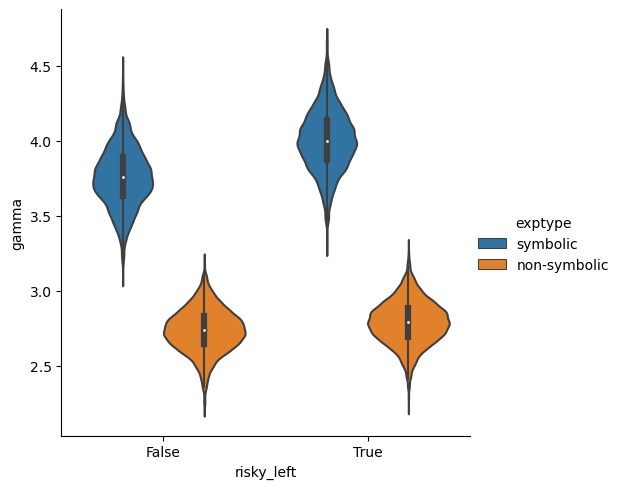

In [21]:
import seaborn as sns
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='risky_left', y='gamma', hue='exptype', kind='violin')

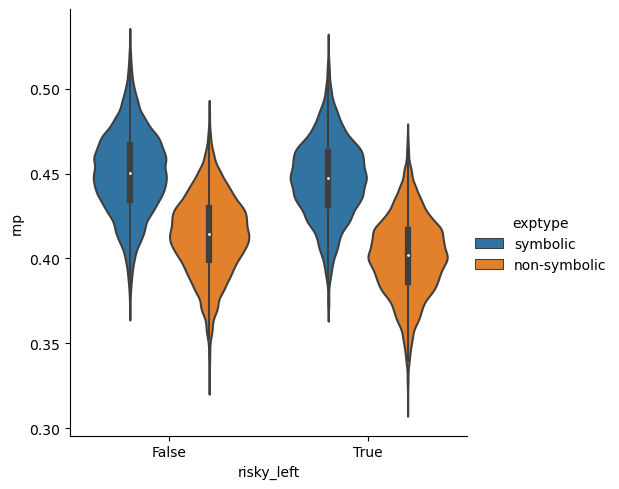

In [20]:
import seaborn as sns
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='risky_left', y='rnp', hue='exptype', kind='violin')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_300/2175267038.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp)


diff    0.847625
dtype: float64

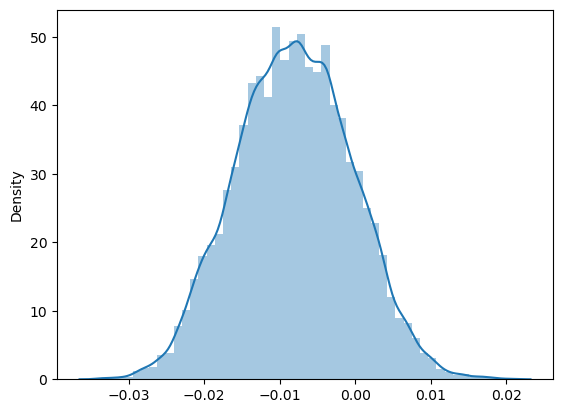

In [28]:
tmp = rnp.stack([1, 2]).unstack('risky_left')
tmp = (tmp[('rnp', True)] - tmp[('rnp', False)] ).to_frame('diff')
sns.distplot(tmp)
(tmp < 0.0).mean()